# Project 2


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time
import torchvision

## Loading the dataset CIFAR10

We are told to classify birds from cats in the CIFAR10 dataset. This means that we will only use the images that are labeled as birds or cats. In the CIFAR10 these labels are 2 and 3 respectively. We will have the training, validation and test datasets.

In [2]:
from torchvision import datasets, transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#Filtering the birds and cats images from the train set
trainset.targets = torch.tensor(trainset.targets)
mask = (trainset.targets == 2) | (trainset.targets == 3)
trainset.targets = (trainset.targets[mask] - 2)  # Adjust labels to be 0 for the birds and 1 cats
trainset.data = trainset.data[mask.numpy().astype(bool)]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)


testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#Filtering the birds and cats images from the test set
testset.targets = torch.tensor(testset.targets)
mask = (testset.targets == 2) | (testset.targets == 3)
testset.targets = (testset.targets[mask] - 2)  # Adjust labels to be 0 for the birds and 1 cats
testset.data = testset.data[mask.numpy().astype(bool)]

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:02<00:00, 59171874.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Splitting the training into train and valid (80/20)

## Implementation of a Lenet5

In [3]:
class Lenet5(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_part = nn.Sequential( # As images are rgb we have 3 input channels
            nn.Conv2d(in_channels=3, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # The input dimension at the classifier is 16 images of 5x5 so 16*5*5
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = self.conv_part(x)
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classifier(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)
                #print(torch.exp(outputs))
                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [4]:
model = Lenet5()
model.trainloop(trainloader,testloader,30)


GPU not available, running CPU
Epoch 1. Training loss: 0.588892, Validation loss: 0.531992, Time per epoch: 14.048660 seconds
Epoch 2. Training loss: 0.503163, Validation loss: 0.511276, Time per epoch: 7.435561 seconds
Epoch 3. Training loss: 0.473874, Validation loss: 0.479535, Time per epoch: 7.559257 seconds
Epoch 4. Training loss: 0.444868, Validation loss: 0.467333, Time per epoch: 6.308069 seconds
Epoch 5. Training loss: 0.410374, Validation loss: 0.464713, Time per epoch: 7.625660 seconds
Epoch 6. Training loss: 0.385587, Validation loss: 0.431779, Time per epoch: 6.165770 seconds
Epoch 7. Training loss: 0.366854, Validation loss: 0.439075, Time per epoch: 7.297690 seconds
Epoch 8. Training loss: 0.344835, Validation loss: 0.409712, Time per epoch: 6.431266 seconds
Epoch 9. Training loss: 0.328710, Validation loss: 0.415189, Time per epoch: 7.015682 seconds
Epoch 10. Training loss: 0.307526, Validation loss: 0.444915, Time per epoch: 6.748130 seconds
Epoch 11. Training loss: 0.

8 epochs for early stopping

## Computing the Calibration Curve

In [5]:
# First we select the true labels of the test data
true_labels = testloader.dataset.targets.numpy()

# The store the output value of the model for each image in the test set
ac, outputs = model.compute_accuracy(testloader)
outputs = np.concatenate(outputs) # concatenate the list of tensors into a single tensor

# Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]

print(predicted_prob)
print(max(predicted_prob))

[0.9857655, 0.9985511, 0.0010634619, 0.030909631, 0.9529138, 0.9999709, 0.99976915, 0.059040215, 0.05241843, 2.0987318e-07, 0.081127115, 0.014808245, 2.8299407e-09, 0.9999969, 0.9822891, 0.0038599363, 4.734491e-08, 0.030439856, 1.0, 0.99744785, 0.00014964136, 0.81720114, 0.27041134, 0.9999987, 1.0896575e-05, 0.9999515, 4.89556e-05, 0.99997485, 1.5493802e-07, 0.99801093, 0.1098581, 0.51593053, 3.584884e-05, 1.1143899e-07, 0.9997038, 0.9951395, 0.03282907, 0.34325397, 0.031631462, 0.8864848, 0.99993336, 0.008602939, 0.99821836, 0.0019431185, 0.1973389, 0.0007233379, 0.99999416, 0.99999905, 0.23310626, 0.009689272, 0.9999993, 0.99999547, 0.029195977, 0.9999999, 0.0007745506, 0.9999999, 0.039773665, 0.0059566237, 0.00020466308, 0.9909073, 0.009950887, 0.021099746, 0.6401625, 0.999997, 0.99350655, 1.2159991e-06, 2.8953176e-08, 0.81202126, 0.0011970138, 0.004795161, 0.60556996, 3.1031238e-09, 0.0022209096, 0.0036582767, 0.0017178905, 6.3234876e-11, 0.9857432, 0.00010821521, 1.0, 1.0, 0.00020

True labels:  [0.18232044 0.45454545 0.48571429 0.48148148 0.48       0.5862069
 0.65517241 0.54285714 0.66037736 0.83496333] 

Predicted Probabilities: [0.00803237 0.1471136  0.25212039 0.34957991 0.45560292 0.55404561
 0.64726571 0.74596813 0.84971112 0.99168236]


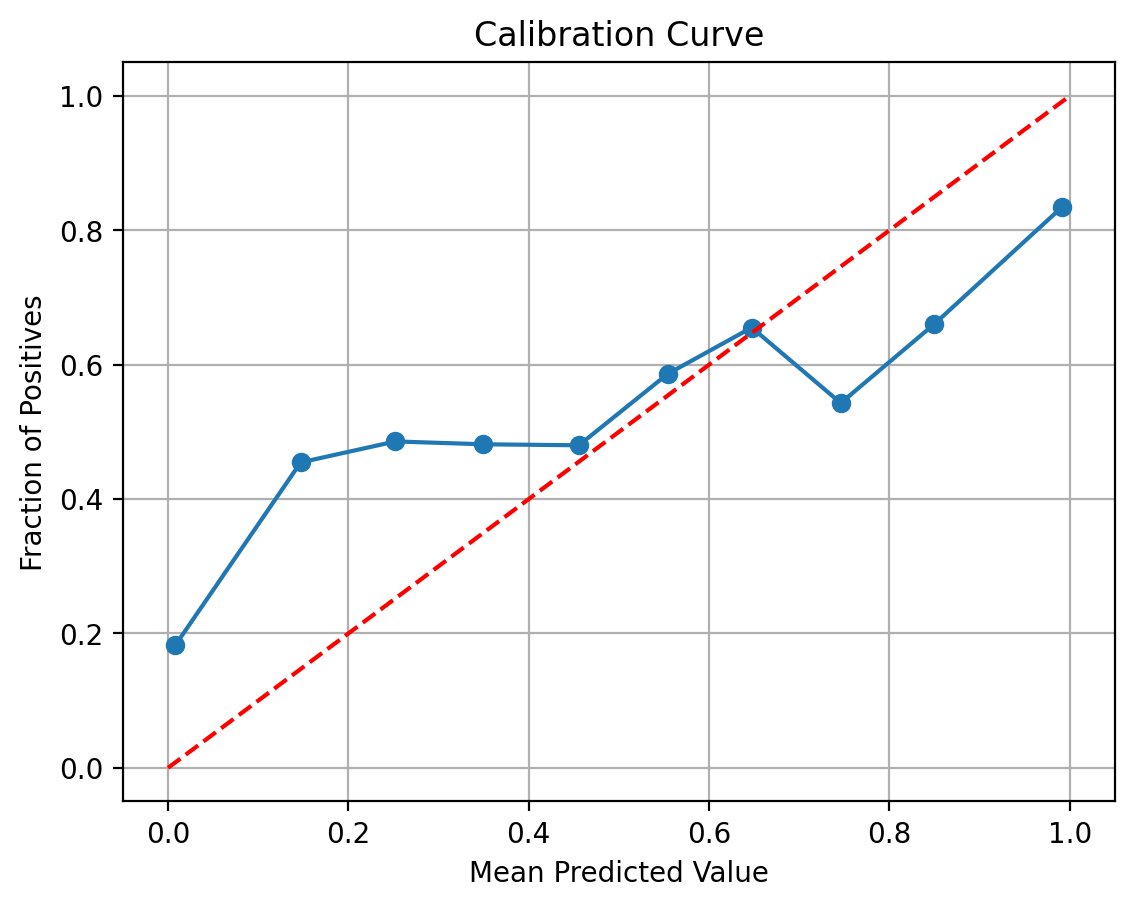

In [6]:
from sklearn.calibration import calibration_curve


prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [7]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.1461


Lenet5 regularized


In [8]:
class Lenet5_regularized(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_part = nn.Sequential( # As images are rgb we have 3 input channels
            nn.Conv2d(in_channels=3, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # The input dimension at the classifier is 16 images of 5x5 so 16*5*5
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = self.conv_part(x)
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classifier(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [9]:
model = Lenet5_regularized()
model.trainloop(trainloader,testloader,8)

GPU not available, running CPU
Epoch 1. Training loss: 0.593053, Validation loss: 0.563097, Time per epoch: 7.469391 seconds
Epoch 2. Training loss: 0.497983, Validation loss: 0.500231, Time per epoch: 6.140325 seconds
Epoch 3. Training loss: 0.465043, Validation loss: 0.468726, Time per epoch: 7.342772 seconds
Epoch 4. Training loss: 0.442594, Validation loss: 0.445641, Time per epoch: 6.181896 seconds
Epoch 5. Training loss: 0.417385, Validation loss: 0.444908, Time per epoch: 7.404104 seconds
Epoch 6. Training loss: 0.396840, Validation loss: 0.437738, Time per epoch: 6.094738 seconds
Epoch 7. Training loss: 0.377020, Validation loss: 0.445986, Time per epoch: 7.473034 seconds
Epoch 8. Training loss: 0.357523, Validation loss: 0.429381, Time per epoch: 6.012213 seconds


In [10]:
# First we select the true labels of the test data
true_labels = testloader.dataset.targets.numpy()

# The store the output value of the model for each image in the test set
ac, outputs = model.compute_accuracy(testloader)
outputs = np.concatenate(outputs) # concatenate the list of tensors into a single tensor

# Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]


True labels:  [0.06813187 0.16949153 0.32142857 0.44210526 0.45882353 0.59375
 0.58333333 0.67826087 0.8436019  0.92144374] 

Predicted Probabilities: [0.0456041  0.14315565 0.24629981 0.34431615 0.4512121  0.55339866
 0.65367597 0.75055494 0.85463055 0.96189999]


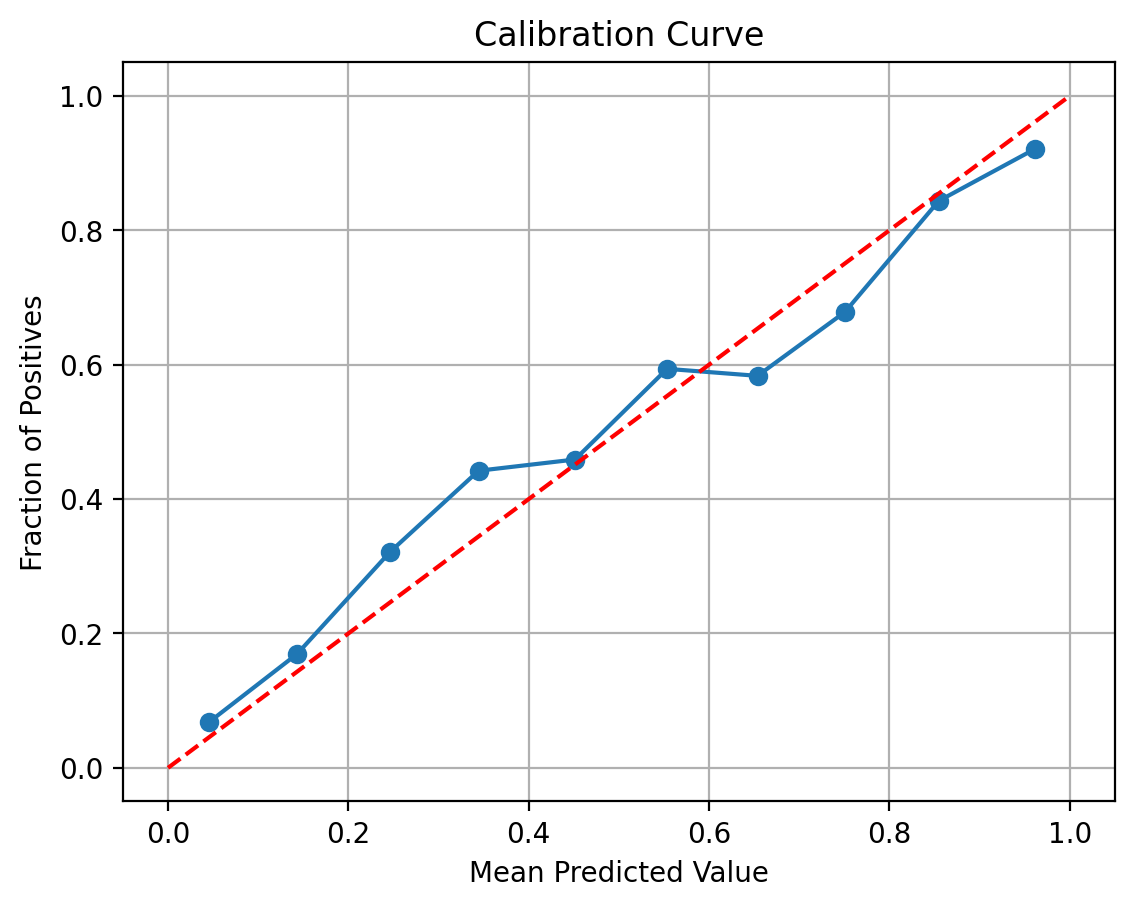

In [11]:
prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [12]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0464


# Platt scaling

For Platt scaling we have to enter our outputs (the ones obtained for the true class) multiplied by a constant a into a new sigmoid

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Fitting a logistic regression model
lr = LogisticRegression()
lr.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Platt scaling using CalibratedClassifierCV
platt_scale = CalibratedClassifierCV(lr, method='sigmoid', cv='prefit')
platt_scale.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Applying Platt scaling
platt_scaled_probs = platt_scale.predict_proba(np.array(predicted_prob).reshape(-1, 1))[:, 1]



True labels:  [0.03755869 0.13441955 0.32885906 0.475      0.47222222 0.57333333
 0.6        0.62878788 0.85347044 0.94267516] 

Predicted Probabilities: [0.09130285 0.1357859  0.24375974 0.34274195 0.44879449 0.54981777
 0.64521631 0.75209591 0.86385603 0.91220535]


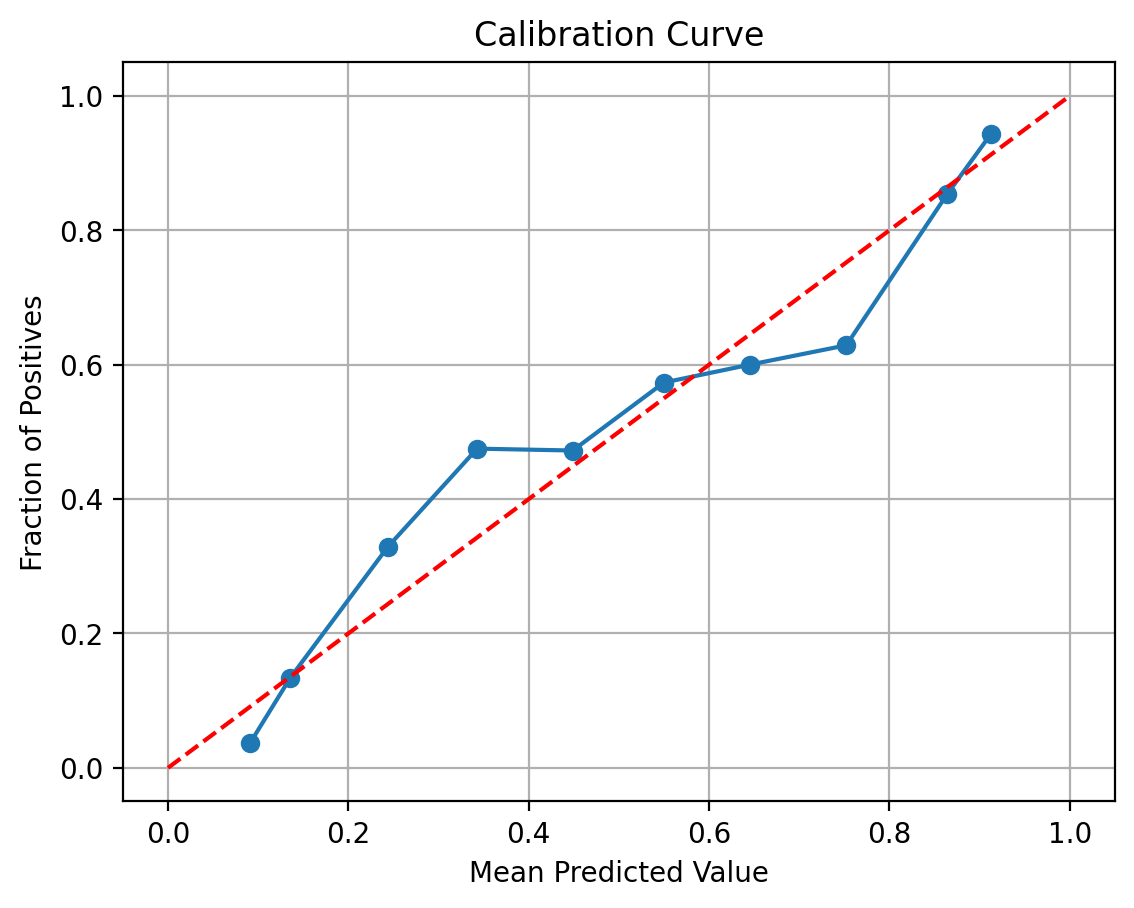

In [14]:
prob_true, prob_pred = calibration_curve(true_labels, platt_scaled_probs, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [15]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0529


# Optional part

We will use a pre-trained model, in this case, the DenseNet

In [16]:
from torchvision import models
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 54.8MB/s]


We will change the classifier part of the DenseNet by the one we have also used in Lenet5 for the classification part


In [17]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.classify = nn.Sequential(
            nn.Linear(1024, 120), # The input dimension at the classifier is 1024, see DenseNet
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classify(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [18]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = Classifier()

model.classifier = classifier

GPU not available, running CPU


Class for training the new model

In [19]:
class Tran_Eval():


    def __init__(self,model,maxiter=30,lr=0.001):

        self.model = model

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)

        self.max_iter = maxiter

        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)

    def trainloop(self,trainloader):

        # Optimization Loop

        it_images = iter(trainloader)

        running_loss = 0.

        self.model.train()

        for e in range(int(self.max_iter)):


            images,labels = next(it_images)


            # Move input and label tensors to the default device
            images, labels = images.to(self.device), labels.to(self.device)

            self.optim.zero_grad()  #TO RESET GRADIENTS!

            out = self.model.forward(images) #YOUR CODE HERE


            loss = self.criterion(out,labels) #YOUR CODE HERE

            running_loss = loss.item()

            #Your code here
            loss.backward()

            #Your code here
            self.optim.step()

            self.loss_during_training.append(running_loss)

            print('Epoch %d of %d finished. Loss %f' %(e+1,self.max_iter,running_loss))


    def compute_accuracy(self,model, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.model.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model.forward(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list

In [20]:
model_with_train = Tran_Eval(model,maxiter=10)

In [21]:
model_with_train.trainloop(trainloader)

Epoch 1 of 10 finished. Loss 0.703515
Epoch 2 of 10 finished. Loss 0.646723
Epoch 3 of 10 finished. Loss 0.623527
Epoch 4 of 10 finished. Loss 0.672038
Epoch 5 of 10 finished. Loss 0.682106
Epoch 6 of 10 finished. Loss 0.736292
Epoch 7 of 10 finished. Loss 0.676457
Epoch 8 of 10 finished. Loss 0.676525
Epoch 9 of 10 finished. Loss 0.645238
Epoch 10 of 10 finished. Loss 0.663539


In [22]:
# First we select the true labels of the test data
true_labels = testloader.dataset.targets.numpy()

# The store the output value of the model for each image in the test set
ac, outputs = model_with_train.compute_accuracy(model,testloader)
outputs = np.concatenate(outputs) # concatenate the list of tensors into a single tensor

# Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]

True labels:  [0.06451613 0.26169265 0.70384615 1.         1.        ] 

Predicted Probabilities: [0.28269993 0.36843105 0.4331705  0.51557709 0.602238  ]


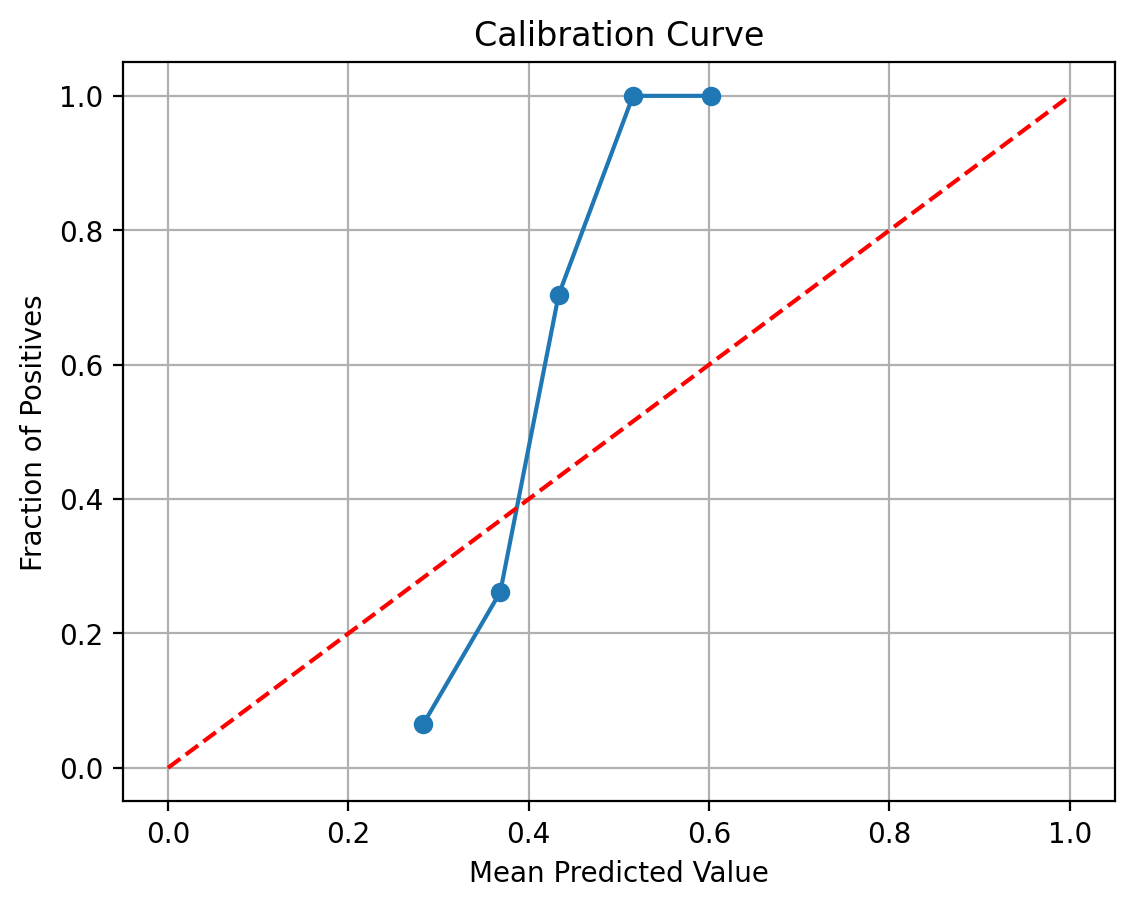

In [23]:
prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [24]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.2956


We add now Platt scaling

In [25]:
# Fitting a logistic regression model
lr = LogisticRegression()
lr.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Platt scaling using CalibratedClassifierCV
platt_scale = CalibratedClassifierCV(lr, method='sigmoid', cv='prefit')
platt_scale.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Applying Platt scaling
platt_scaled_probs = platt_scale.predict_proba(np.array(predicted_prob).reshape(-1, 1))[:, 1]

True labels:  [0.09401709 0.14659686 0.27542373 0.34299517 0.36947791 0.58874459
 0.62396694 0.760181   0.88372093 0.94029851] 

Predicted Probabilities: [0.05486024 0.15102612 0.24983666 0.35201318 0.44808637 0.55042918
 0.64753936 0.74915918 0.84970241 0.93855979]


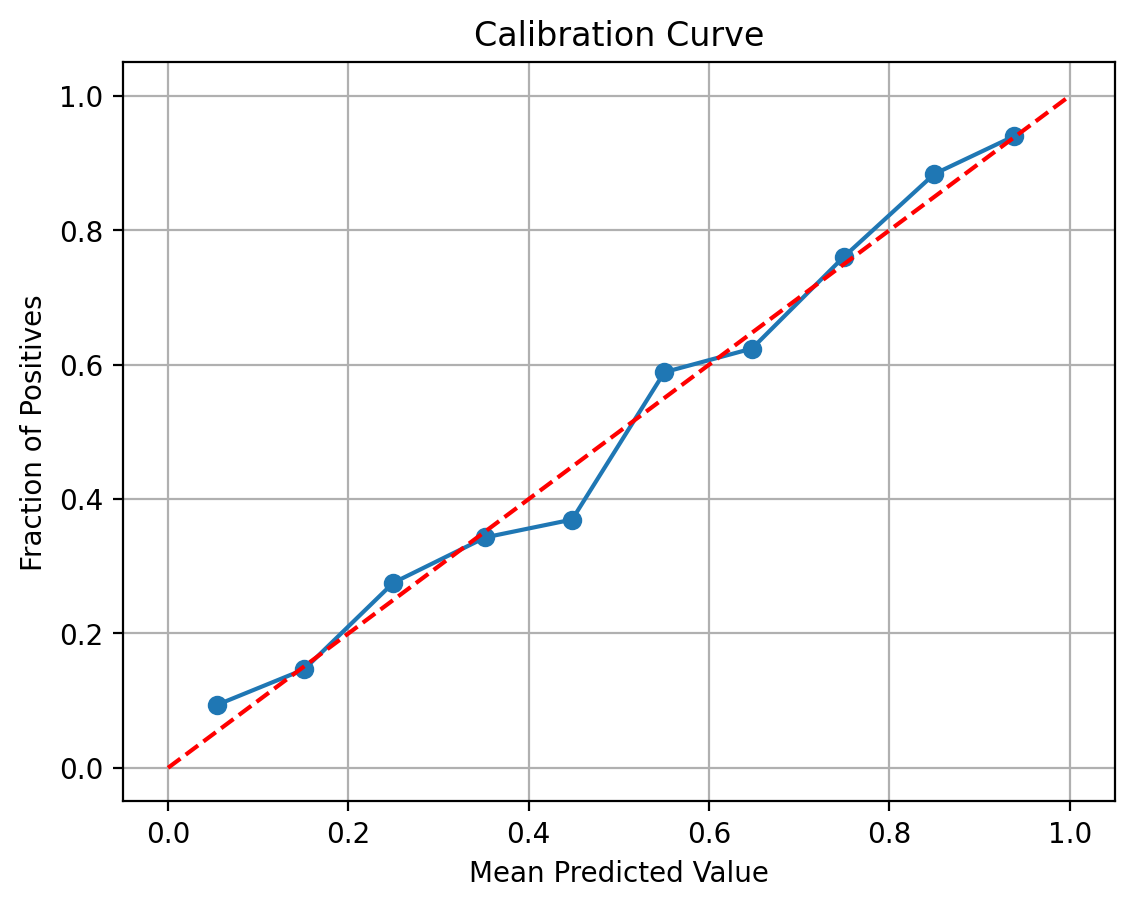

In [26]:
prob_true, prob_pred = calibration_curve(true_labels, platt_scaled_probs, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [27]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0265
